In [140]:
import pandas as pd
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
import tensorflow as tf
import numpy as np
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from ampligraph.utils import save_model
import csv
from sklearn.metrics import accuracy_score, classification_report

input_file = "lovecraft_ontology.csv"
output_file = "fixed_lovecraft_ontology.csv"

def fix_csv(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8', newline='') as outfile:
        reader = csv.reader(infile, delimiter=',')
        writer = csv.writer(outfile, delimiter=',')

        for row in reader:
            # Проверяем, чтобы строка имела только 3 колонки
            if len(row) > 3:
                # Соединяем все "лишние" части в третью колонку
                fixed_row = row[:2] + [','.join(row[2:])]
                writer.writerow(fixed_row)
            else:
                writer.writerow(row)

# Запуск функции
fix_csv(input_file, output_file)

print(f"Файл исправлен и сохранён как {output_file}")

file_path = "fixed_lovecraft_ontology.csv"
triplets = pd.read_csv(file_path, delimiter=',')


print("Пример данных:")
print(triplets.head())


nan_values = triplets[triplets.isnull().any(axis=1)]
if not nan_values.empty:
    print("\nСтроки с NaN значениями:")
    print(nan_values)
else:
    print("\nNaN значения не найдены.")


empty_strings = triplets[
    (triplets['Subject'].astype(str).str.strip() == '') |
    (triplets['Predicate'].astype(str).str.strip() == '') |
    (triplets['Object'].astype(str).str.strip() == '')
]

if not empty_strings.empty:
    print("\nСтроки с пустыми строками или пробелами:")
    print(empty_strings)
else:
    print("\nПустых строк или строк с пробелами не найдено.")


Файл исправлен и сохранён как fixed_lovecraft_ontology.csv
Пример данных:
                                             Subject  \
0    http://example.org/lovecraft#A_Home_for_Cthulhu   
1       http://example.org/lovecraft#Coffin_of_Glass   
2        http://example.org/lovecraft#Simon_Canfield   
3  http://example.org/lovecraft#The_Man_Who_Was_L...   
4              http://example.org/lovecraft#Punktown   

                                         Predicate  \
0      http://example.org/lovecraft#wasReleasedOnW   
1  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
2       http://example.org/lovecraft#wasCreatedByC   
3  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
4       http://example.org/lovecraft#hasAnnotation   

                                              Object  
0                                           May 2022  
1          http://example.org/lovecraft#OtherAuthors  
2                                 Elizabeth Berkeley  
3                  http://example.org/lovecr

In [90]:
file_path = "fixed_lovecraft_ontology.csv"
triplets = pd.read_csv(file_path, delimiter=',')

# Подсчет общего количества NaN
total_nan_count = triplets.isnull().sum().sum()

# Подсчет NaN в каждом столбце
nan_per_column = triplets.isnull().sum()

# Вывод результатов
print(f"Общее количество NaN значений: {total_nan_count}\n")
print("Количество NaN значений в каждом столбце:")
print(nan_per_column)


Общее количество NaN значений: 11

Количество NaN значений в каждом столбце:
Subject       0
Predicate     0
Object       11
dtype: int64


In [91]:
cleaned_triplets = triplets.dropna()
cleaned_file_path = "cleaned_lovecraft_ontology.csv"
cleaned_triplets.to_csv(cleaned_file_path, index=False)

print(f"Очищенный файл сохранён как {cleaned_file_path}")
print(f"Количество оставшихся строк: {len(cleaned_triplets)}")


Очищенный файл сохранён как cleaned_lovecraft_ontology.csv
Количество оставшихся строк: 54397


In [92]:
file_path = "cleaned_lovecraft_ontology.csv"
triplets = pd.read_csv(file_path, delimiter=',')
total_nan_count = triplets.isnull().sum().sum()
nan_per_column = triplets.isnull().sum()
print(f"Общее количество NaN значений: {total_nan_count}\n")
print("Количество NaN значений в каждом столбце:")
print(nan_per_column)


Общее количество NaN значений: 0

Количество NaN значений в каждом столбце:
Subject      0
Predicate    0
Object       0
dtype: int64


In [93]:
file_path = "cleaned_lovecraft_ontology.csv"
triplets = pd.read_csv(file_path)

def remove_prefix(value):
    if isinstance(value, str) and "http://" in value:
        return value.split('#')[-1]  # Оставляем только часть после '#'
    return value

triplets['Subject'] = triplets['Subject'].apply(remove_prefix)
triplets['Predicate'] = triplets['Predicate'].apply(remove_prefix)
triplets['Object'] = triplets['Object'].apply(remove_prefix)
cleaned_file_path = "cleaned_triplets_splitted.csv"
triplets.to_csv(cleaned_file_path, index=False)

print(f"Очищенные данные сохранены в {cleaned_file_path}")
print(triplets.head())


Очищенные данные сохранены в cleaned_triplets_splitted.csv
                     Subject       Predicate  \
0         A_Home_for_Cthulhu  wasReleasedOnW   
1            Coffin_of_Glass            type   
2             Simon_Canfield   wasCreatedByC   
3  The_Man_Who_Was_Lovecraft            type   
4                   Punktown   hasAnnotation   

                                              Object  
0                                           May 2022  
1                                       OtherAuthors  
2                                 Elizabeth Berkeley  
3                                               Work  
4  Paxton is a fictional city on an alien planet ...  


## После чистки данных выше приступаем к созданию эмбеддингов

In [103]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
file_path = "cleaned_triplets_splitted.csv"
triplets = pd.read_csv(file_path).to_numpy()
np.random.shuffle(triplets)
X_train, X_valid = train_test_split_no_unseen(triplets, test_size=0.2)


print(f"Размер обучающей выборки: {len(X_train)} триплетов")
print(f"Размер тестовой выборки: {len(X_valid)} триплетов")


Размер обучающей выборки: 43518 триплетов
Размер тестовой выборки: 10879 триплетов


In [104]:
model = ScoringBasedEmbeddingModel(
    k=300, 
    eta=30,
    scoring_type='ComplEx',
    seed=0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)


In [105]:
model.fit(X_train, batch_size=int(X_train.shape[0] / 50), epochs=100, verbose=True)


Epoch 1/100
52/52 [==============================] - 7s 136ms/step - loss: 2930.1992
Epoch 2/100
52/52 [==============================] - 6s 124ms/step - loss: 2930.1069
Epoch 3/100
52/52 [==============================] - 6s 124ms/step - loss: 2930.0002
Epoch 4/100
52/52 [==============================] - 6s 124ms/step - loss: 2929.8547
Epoch 5/100
52/52 [==============================] - 6s 124ms/step - loss: 2929.6365
Epoch 6/100
52/52 [==============================] - 6s 124ms/step - loss: 2929.2861
Epoch 7/100
52/52 [==============================] - 6s 124ms/step - loss: 2928.7173
Epoch 8/100
52/52 [==============================] - 6s 124ms/step - loss: 2927.8152
Epoch 9/100
52/52 [==============================] - 6s 124ms/step - loss: 2926.4404
Epoch 10/100
52/52 [==============================] - 6s 124ms/step - loss: 2924.4409
Epoch 11/100
52/52 [==============================] - 6s 124ms/step - loss: 2921.6716
Epoch 12/100
52/52 [==============================] - 6s 124ms/

In [144]:
ranks = model.evaluate(
    X_valid,
    use_filter={'train': X_train, 'test': X_valid},  
    corrupt_side='s,o',  
    verbose=True  
)

mr = mr_score(ranks)
mrr = mrr_score(ranks)
hits_10 = hits_at_n_score(ranks, n=10)
hits_3 = hits_at_n_score(ranks, n=3)
hits_1 = hits_at_n_score(ranks, n=1)

print("Mean Reciprocal Rank (MRR): %.2f" % mrr)
print("Mean Rank (MR): %.2f" % mr)
print("Hits@10: %.2f" % hits_10)
print("Hits@3: %.2f" % hits_3)
print("Hits@1: %.2f" % hits_1)

1089/1089 [==============================] - 118s 108ms/step
Mean Reciprocal Rank (MRR): 0.32
Mean Rank (MR): 1158.34
Hits@10: 0.43
Hits@3: 0.35
Hits@1: 0.26


In [107]:
entities = np.unique(np.concatenate([X_train[:, 0], X_train[:, 2]]))
entity_embeddings = model.get_embeddings(entities)
entity_embeddings_df = pd.DataFrame(entity_embeddings, index=entities)
entity_embeddings_df.to_csv("entity_embeddings.csv", header=False)
print("Эмбединги успешно сохранены в файл entity_embeddings.csv")


Эмбединги успешно сохранены в файл entity_embeddings.csv


In [108]:
save_model(model, "path_to_saved_model.pkl")
print("Модель успешно сохранена.")

The path path_to_saved_model.pkl already exists. This save operation will overwrite the model                 at the specified path.
WARNING - Found untraced functions such as _get_ranks while saving (showing 1 of 1). These functions will not be directly callable after loading.
Модель успешно сохранена.


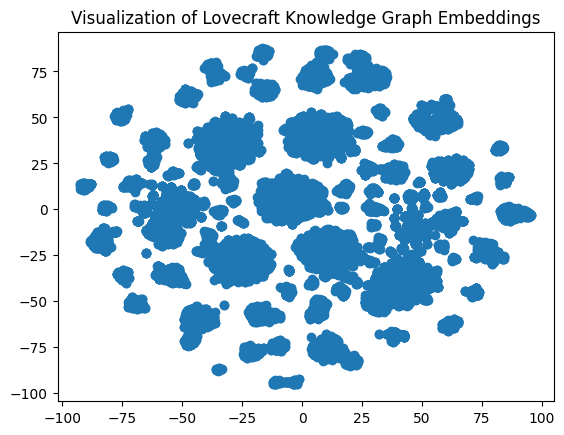

In [109]:
emb_2d = TSNE(n_components=2, random_state=42).fit_transform(entity_embeddings)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.title("Visualization of Lovecraft Knowledge Graph Embeddings")
plt.show()


## На основе эмбеддингов посмотрим наиболее близких к стилю лавкрафта авторов (своего рода вероятных авторов)

In [126]:
import numpy as np
import pandas as pd
from scipy.special import expit
from ampligraph.utils import save_model, restore_model

def load_triplets(file_path):
    """
    Загрузка триплетов из CSV файла.
    """
    return pd.read_csv(file_path).to_numpy()

def load_model(model_path):
    """
    Загрузка обученной модели.
    """
    model = restore_model(model_path)
    print("Модель успешно загружена.")
    return model

def suggest_alternative_authors(triplets, model):
    """
    Предлагает альтернативных авторов для произведений Лавкрафта.
    """
    df = pd.DataFrame(triplets, columns=['subject', 'predicate', 'object'])
    was_written_by = df[(df['predicate'] == 'hasAuthorW') & (df['object'] == 'H._P._Lovecraft')]

    if was_written_by.empty:
        print("Нет произведений Лавкрафта в данных.")
        return

    print(f"Найдено {len(was_written_by)} произведений Лавкрафта.")
    possible_authors = ["August Derleth", "Clark Ashton Smith", "Robert E. Howard", 
                        "Frank Belknap Long", "Ramsey Campbell", "Brian Lumley", "Lin Carter", 
                        "William Hope Hodgson", "Thomas Ligotti", "Fritz Leiber", "Robert Bloch"]

    test_statements = []
    for _, row in was_written_by.iterrows():
        for author in possible_authors:
            test_statements.append([row['subject'], 'hasAuthorW', author])

    test_statements = np.array(test_statements)
    print("Test statements shape:", test_statements.shape)

    if test_statements.size == 0:
        print("Нет тестовых заявлений для предсказания.")
        return

    scores = model.predict(test_statements)
    probs = expit(scores)

    results = pd.DataFrame({
        'Work': [statement[0] for statement in test_statements],
        'Alternative Author': [statement[2] for statement in test_statements],
        'Score': scores,
        'Probability': probs
    }).sort_values(by=['Work', 'Probability'], ascending=[True, False])
    top_alternatives = results.groupby('Work').first().reset_index()
    print("\nНаиболее вероятные альтернативные авторы для произведений Лавкрафта:")
    print(top_alternatives.head(10))

    return top_alternatives

file_path = "cleaned_triplets_splitted.csv"
model_path = "path_to_saved_model.pkl"

triplets = load_triplets(file_path)
model = load_model(model_path)

alternative_authors = suggest_alternative_authors(triplets, model)

alternative_authors.to_csv("alternative_authors.csv", index=False)


Saved model does not include a db file. Skipping.
Модель успешно загружена.
Найдено 268 произведений Лавкрафта.
Test statements shape: (2948, 3)

Наиболее вероятные альтернативные авторы для произведений Лавкрафта:
                                                Work Alternative Author  \
0                            A_Confession_of_Unfaith       Brian Lumley   
1  A_Description_of_the_Town_of_Quebeck,_in_New_F...       Brian Lumley   
2               A_Reminiscence_of_Dr._Samuel_Johnson       Brian Lumley   
3                      A_Winter_Wish_and_Other_Poems       Brian Lumley   
4                        Ad_Criticos:_Liber_Secundus     Thomas Ligotti   
5                    Advice_for_the_Weird_Fictioneer       Brian Lumley   
6                                   Against_Religion       Brian Lumley   
7                                 Alfredo:_A_Tragedy     Thomas Ligotti   
8  Amateur_Journalism:_Its_Possible_Needs_and_Bet...     Thomas Ligotti   
9                      An_American_

In [127]:
def analyze_alternative_authors(file_path):
    """
    Анализирует файл alternative_authors.csv и выводит авторов,
    которые встречаются чаще всего.
    
    :param file_path: Путь к файлу alternative_authors.csv
    """
    data = pd.read_csv(file_path)
    if 'Alternative Author' not in data.columns:
        print("Ошибка: В файле отсутствует столбец 'Alternative Author'.")
        return
    author_counts = data['Alternative Author'].value_counts()
    print("Топ-3 альтернативных автора:")
    print(author_counts.head(3))
    return author_counts

file_path = "alternative_authors.csv" 
analyze_alternative_authors(file_path)

Топ-3 альтернативных автора:
Brian Lumley          153
Thomas Ligotti        103
Frank Belknap Long      7
Name: Alternative Author, dtype: int64


Brian Lumley            153
Thomas Ligotti          103
Frank Belknap Long        7
Robert E. Howard          3
William Hope Hodgson      2
Name: Alternative Author, dtype: int64

## Задача линкд предикшн - проверим, поймет ли он, кто реальный автор у ряда произведений. Таким образом и эмбеддинги тестируем

In [141]:


def load_triplets(file_path):

    return pd.read_csv(file_path).to_numpy()

def load_model(model_path):

    model = restore_model(model_path)
    print("Модель успешно загружена.")
    return model

def link_prediction_for_all(triplets, model):
    df = pd.DataFrame(triplets, columns=['subject', 'predicate', 'object'])
    lavcraft_works = df[(df['predicate'] == 'hasAuthorW') & (df['object'] == 'H._P._Lovecraft')]

    if lavcraft_works.empty:
        print("Нет произведений Лавкрафта в данных.")
        return

    print(f"Найдено {len(lavcraft_works)} произведений Лавкрафта.")
        
        # Удаляем связи 'hasAuthorW' для тренировочных данных
    filtered_triplets = df[~((df['predicate'] == 'hasAuthorW') & (df['object'] == 'H._P._Lovecraft'))].to_numpy()
    model.fit(filtered_triplets, epochs=10, verbose=True)

    possible_authors = ["H.P. Lovecraft", "August Derleth", "Clark Ashton Smith", "Robert E. Howard", 
                        "Frank Belknap Long", "Ramsey Campbell", "Brian Lumley", "Lin Carter", 
                        "William Hope Hodgson", "Thomas Ligotti", "Fritz Leiber", "Robert Bloch"]

    test_statements = []
    ground_truth = []

    for _, row in lavcraft_works.iterrows():
        ground_truth.append('H.P. Lovecraft')
        for author in possible_authors:
            test_statements.append([row['subject'], 'hasAuthorW', author])

    test_statements = np.array(test_statements)
    scores = model.predict(test_statements)
    probs = expit(scores)

    results = pd.DataFrame({
            'Work': [statement[0] for statement in test_statements],
            'Predicted Author': [statement[2] for statement in test_statements],
            'Score': scores,
            'Probability': probs
        }).sort_values(by=['Work', 'Probability'], ascending=[True, False])
    top_predictions = results.groupby('Work').first().reset_index()
    print("\nТоп предсказания для произведений Лавкрафта:")
    print(top_predictions.head(10))
    y_pred = top_predictions['Predicted Author'].values
    labels = sorted(set(ground_truth + list(y_pred)))
    print(f"\nAccuracy: {accuracy_score(ground_truth, y_pred) * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(ground_truth, y_pred, labels=labels, target_names=labels))

    return top_predictions

file_path = "cleaned_triplets_splitted.csv"
model_path = "path_to_saved_model.pkl"
triplets = load_triplets(file_path)
model = load_model(model_path)
predictions = link_prediction_for_all(triplets, model)
predictions.to_csv("link_prediction_results.csv", index=False)


Saved model does not include a db file. Skipping.
Модель успешно загружена.
Найдено 268 произведений Лавкрафта.
Epoch 1/10
     40/Unknown - 6s 157ms/step - loss: 479.9680

KeyboardInterrupt: 